# Machine Learning Engineer Nanodegree
## House Prices: Advanced Regression Techniques

In [34]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

# Visuals and graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load training data
train_raw = pd.read_csv('housing/train.csv')
test_raw = pd.read_csv('housing/test.csv')

# Basic exploration
print("The housing dataset has {} data points with {} features each.".format(*test_raw.shape))
test_raw.head(10)

The housing dataset has 1459 data points with 80 features each.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [35]:
# Basic exploration
print("The housing dataset has {} data points with {} features each.".format(*train_raw.shape))
train_raw.head(10)

The housing dataset has 1460 data points with 81 features each.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

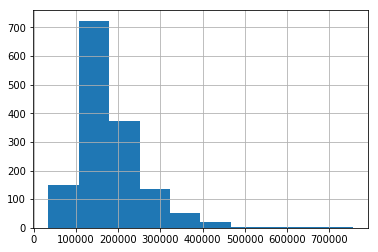

In [2]:
train_raw.SalePrice.hist()
train_raw.SalePrice.describe()

In [3]:
from sklearn.metrics import mean_squared_error, fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
import math

def rmlse(y_true, y_pred):
    result = (math.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred))))
    return result

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Initial training
    model[1].fit(X_train, y_train)
    
    # Use the model to make predictions
    y_pred = model[1].predict(X_test)
    
    # Evaluate with the root mean squared error
    score = rmlse(y_test, y_pred)
    
    return model, score

# The custom one hot encoding below hurt my scores during the testing phase. 
def feature_cat_conversion(column, data, debug=0):
    if debug:
        display(column, data[column].value_counts())
    mapping = {item : index+1 for index, item in enumerate(set(data[column]))}
    #data[column].fillna(0, inplace=True)
    data[column] = data[column].map(mapping)
    if debug:
        display(data[column].value_counts())

def detect_outliers(columns, data):
    # TODO: Calculate Q1 (25th percentile of the data) for the given columns
    Q1 = np.percentile(data[columns], 25)

    Q2 = np.percentile(data[columns], 50)

    # TODO: Calculate Q3 (75th percentile of the data) for the given columns
    Q3 = np.percentile(data[columns], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1) * 1.5

    # Display the outliers
    print "Data points considered outliers for the columns '{}':".format(columns)
    df = data[~((data[columns] >= Q1 - step) & (data[columns] <= Q3 + step))]
    display("{} median: {}".format(columns, Q2))
    display("{} step: {}".format(columns, step))
    display("{} number found: {}".format(columns, len(df.index.tolist())))

    return df.index.tolist()

def grid_search_cv(model, params, X_train, X_test, y_train, y_test, verbose=False):
    rmlse_scorer = make_scorer(rmlse, greater_is_better=False)
    grid = GridSearchCV(model[1], params, scoring=rmlse_scorer)
    grid.fit(X, y)

    #y_pred = grid.predict(X_test)
    #score = rmlse(y_test, y_pred)
    print(model[verbose], grid.best_score_)

In [4]:
# Identify missing data
total = train_raw.isnull().sum().sort_values(ascending=False)
percent = (train_raw.isnull().sum()/train_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
#train_raw.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)
#test_raw.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [5]:
# One hot encode data for data analysis
encoded_train = pd.get_dummies(train_raw)
encoded_test = pd.get_dummies(test_raw)

# Categorical data has been enumerated
print("Features have increased from {} to {}".format(train_raw.shape[1], encoded_train.shape[1]))

Features have increased from 81 to 290


In [6]:
# Find top 10 strongest correlations (+/- included)
corr_values = train_raw.corr().filter(['SalePrice']).drop(['SalePrice'])
corr_values = corr_values.abs()
corr_values.sort_values(by=['SalePrice'], ascending=False).head(10)

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


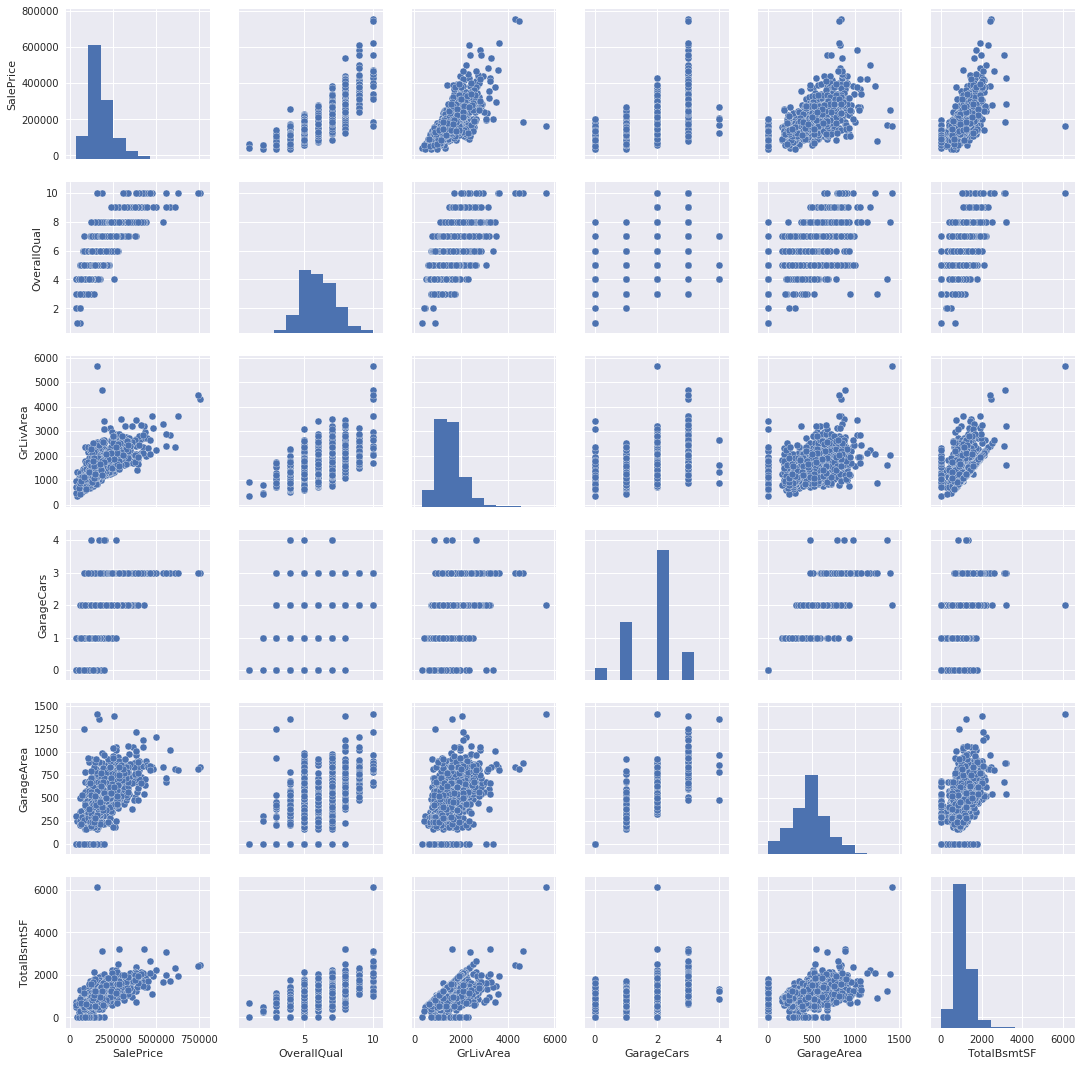

In [7]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
sns.pairplot(encoded_train[cols], size = 2.5)
ax = plt.show();

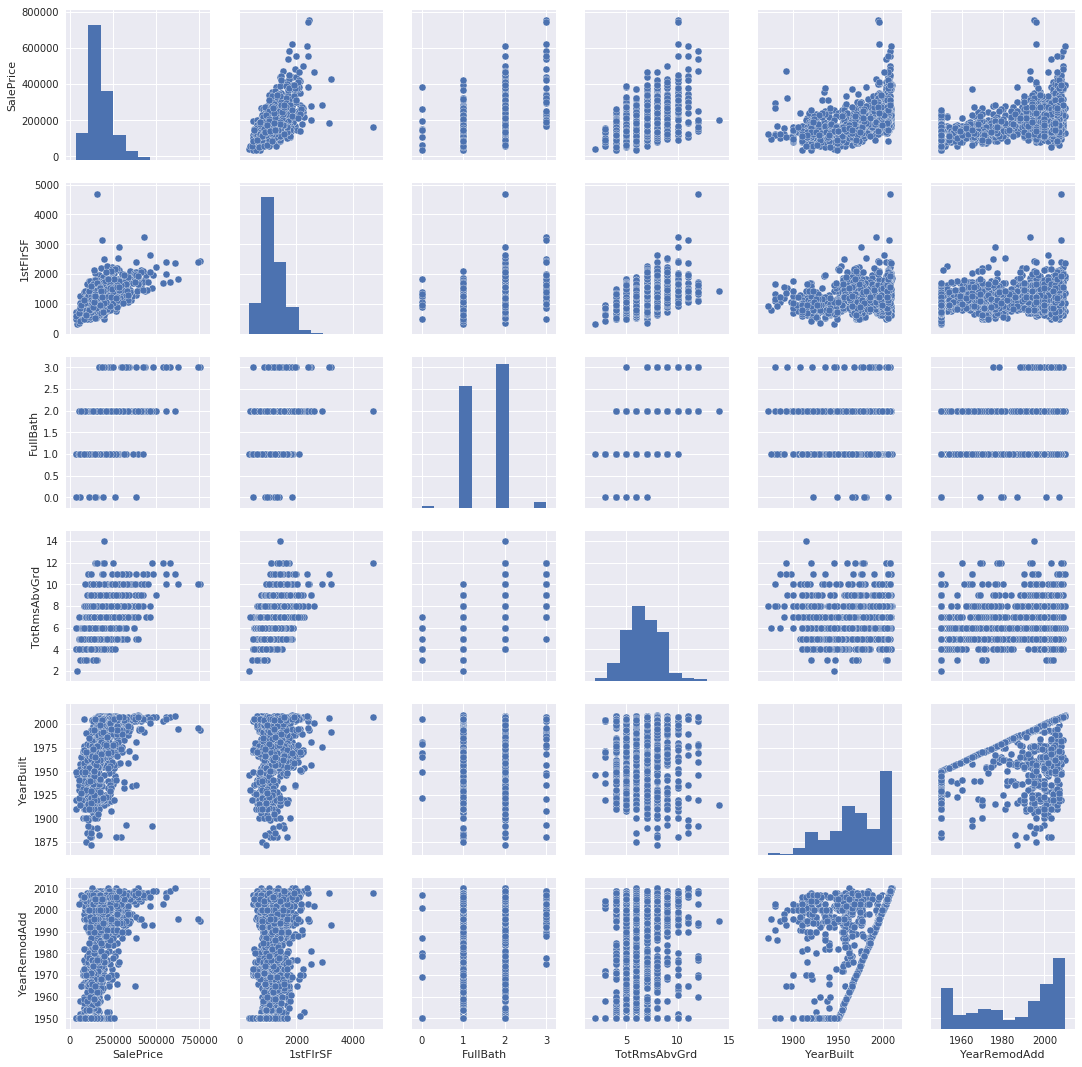

In [8]:
#scatterplot
sns.set()
cols = ['SalePrice', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
ax = sns.pairplot(encoded_train[cols], size = 2.5)


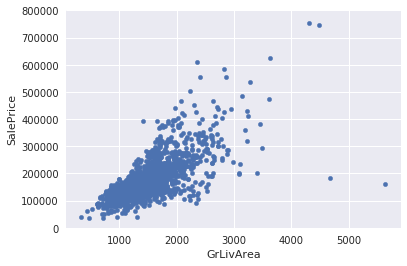

In [9]:
var = 'GrLivArea'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

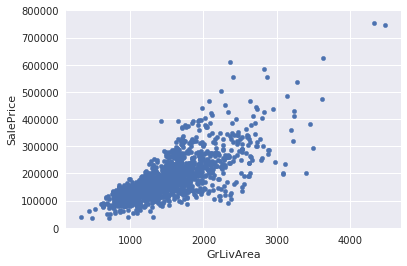

In [10]:
# Remove outliers
outliers = encoded_train[(encoded_train.SalePrice < 300000) & (encoded_train.GrLivArea > 4000)].index.tolist()
encoded_train.drop(outliers, inplace=True)

# Visualize again
var = 'GrLivArea'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

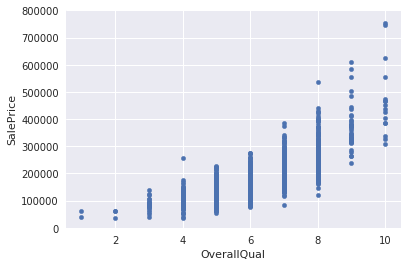

In [11]:
var = 'OverallQual'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

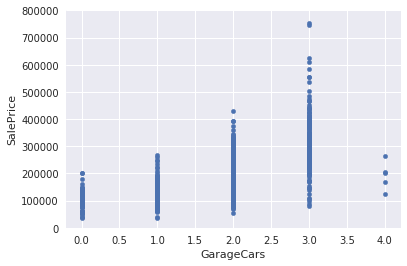

In [12]:
var = 'GarageCars'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

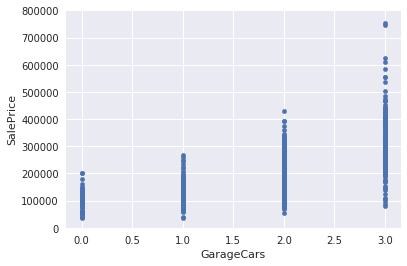

In [13]:
# Remove outliers
outliers = encoded_train[(encoded_train.GarageCars > 3)].index.tolist()
encoded_train.drop(outliers, inplace=True)

# Visualize again
var = 'GarageCars'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

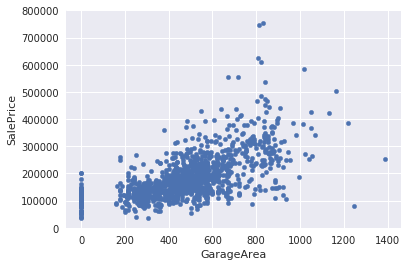

In [14]:
var = 'GarageArea'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [15]:
# Removing these outliers lowered my score
#outliers = encoded_train[(encoded_train.GarageArea > 1200) & (encoded_train.SalePrice < 200000)].index.tolist()
#encoded_train.drop(outliers, inplace=True)

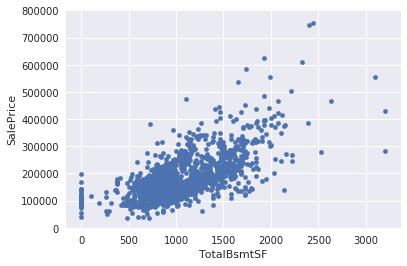

In [16]:
var = 'TotalBsmtSF'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

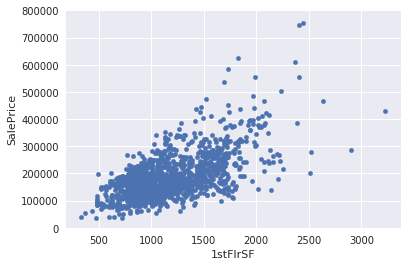

In [17]:
var = '1stFlrSF' 
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

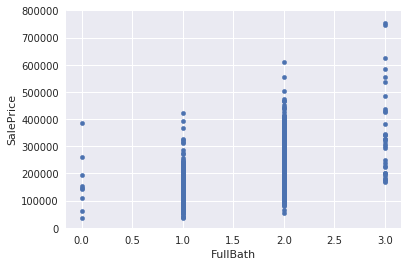

In [18]:
var = 'FullBath' 
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

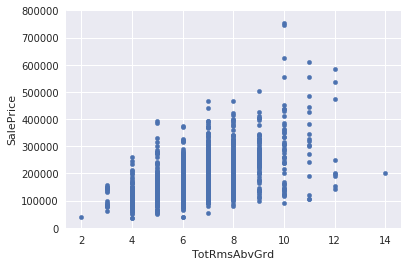

In [19]:
var = 'TotRmsAbvGrd' 
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [20]:
# Negative impact on score
# outliers = encoded_train[(encoded_train.TotRmsAbvGrd > 12)].index.tolist()
# encoded_train.drop(outliers, inplace=True)

# var = 'TotRmsAbvGrd' 
# data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));
# '', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'

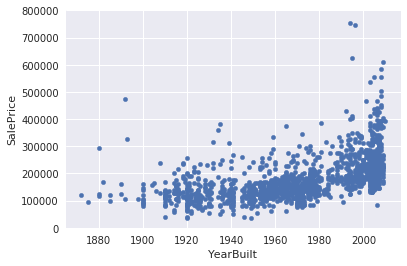

In [21]:
var = 'YearBuilt' 
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [22]:
# Negative impact on score
# outliers = encoded_train[(encoded_train.YearBuilt < 1900) & (encoded_train.SalePrice > 200000)].index.tolist()
# encoded_train.drop(outliers, inplace=True)
# data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));
# detect_outliers('YearBuilt', encoded_test)
# encoded_train.loc[detect_outliers('YearBuilt', encoded_test)]

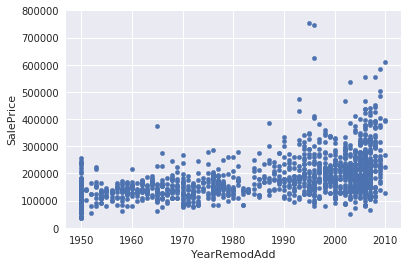

In [23]:
var = 'YearRemodAdd'
data = pd.concat([encoded_train['SalePrice'], encoded_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [24]:
encoded_train.fillna(encoded_train.mean(), inplace=True)
encoded_test.fillna(encoded_test.mean(), inplace=True)

In [25]:
def grid_search_cv(model, params, X_train, X_test, y_train, y_test, verbose=False):
    rmlse_scorer = make_scorer(rmlse, greater_is_better=False)
    grid = GridSearchCV(model[1], params, scoring=rmlse_scorer, n_jobs=1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    score = rmlse(y_test, y_pred)
    print(model[verbose], score)
    return grid

In [26]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
columns = [x for x in encoded_test.columns if x != 'SalePrice']

X = encoded_train[columns]
y = encoded_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = [('ExtraTreesRegressor', ExtraTreesRegressor()),
              ('RandomForestRegressor', RandomForestRegressor(random_state=0)), 
              ('LinearRegression', LinearRegression()), 
              ('Lasso', Lasso(random_state=0)),
              ('Ridge', Ridge(random_state=0)),
              ('SVR', SVR()),
              ('ElasticNet', ElasticNet(random_state=0)),
              ('XGBRegressor', XGBRegressor())]
for model in models:
    try:
        grid_search_cv(model, {}, X_train, X_test, y_train, y_test, 0)
    except Exception as e:
        print(e)

('ExtraTreesRegressor', 0.15043385394589587)
('RandomForestRegressor', 0.13598224120627594)
Input contains NaN, infinity or a value too large for dtype('float64').


/home/dhonda/bin/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/dhonda/bin/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Input contains NaN, infinity or a value too large for dtype('float64').
('Ridge', 0.1273511948017032)
('SVR', 0.4001361051587584)
Input contains NaN, infinity or a value too large for dtype('float64').
('XGBRegressor', 0.11762318406541293)


In [27]:
# GridSearchCV ExtraTreesRegressor for optimum parameters
# Default   0.13990168842252845
# Optimized 0.127627275490006
model_type = 'ExtraTreesRegressor'
model = (model_type, ExtraTreesRegressor(random_state=0))
params = {'n_estimators': [5, 10, 100, 200, 500],
          'max_depth': range(1, 10) + [None],
          'max_features': ['auto', 'sqrt', 'log2']}
grid_model = grid_search_cv(model, params, X_train, X_test, y_train, y_test, True)
predicted_prices = grid_model.predict(encoded_test[columns])
submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
submission.to_csv(model_type + '.csv', index=False)

(ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=0, verbose=0, warm_start=False), 0.13715181985704825)


In [28]:
# GridSearchCV RandomForestRegressor for optimum parameters
# Default   0.13281658240316863
# Optimized 0.1276171108919893
model_type = 'RandomForestRegressor'
model = (model_type, RandomForestRegressor(random_state=0))
params = {'n_estimators': [5, 10, 100, 200, 500],
          'max_depth': range(1, 10) + [None],
          'max_features': ['auto', 'sqrt', 'log2']}
grid_model = grid_search_cv(model, params, X_train, X_test, y_train, y_test, True)
predicted_prices = grid_model.predict(encoded_test[columns])
submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
submission.to_csv(model_type + '.csv', index=False)

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False), 0.13099042528540938)


In [30]:
# GridSearchCV LinearRegression for optimum parameters
# Default   0.13795092363295428
# Optimized 0.13795092363295428
model_type = 'LinearRegression'
model = (model_type, LinearRegression())
#params = {'fit_intercept': [True, False]}
params = {}
grid_model = grid_search_cv(model, params, X_train, X_test, y_train, y_test, True)
predicted_prices = grid_model.predict(encoded_test[columns])
submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
submission.to_csv(model_type + '.csv', index=False)

/home/dhonda/bin/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# GridSearchCV Lasso for optimum parameters
# Default   0.13637081631363016
# Optimized 0.13795092363295428
model_type = 'Lasso'
model = (model_type, Lasso(random_state=0))
params = {'alpha': [0.001, .01, 1],
          'max_iter': [500, 1000, 1500]}
#params = {}
grid_model = grid_search_cv(model, params, X_train, X_test, y_train, y_test, True)
predicted_prices = grid_model.predict(encoded_test[columns])
submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
submission.to_csv(model_type + '.csv', index=False)

In [ ]:
# GridSearchCV Ridge for optimum parameters
# Default   0.12681603804409897
# Optimized 0.13795092363295428
model_type = 'Ridge'
model = (model_type, Ridge(random_state=0))
params = {'alpha': [0.001, .01, 1],
          'max_iter': [500, 1000, 1500],
          'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
#params = {}
grid_model = grid_search_cv(model, params, X_train, X_test, y_train, y_test, True)
predicted_prices = grid_model.predict(encoded_test[columns])
submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
submission.to_csv(model_type + '.csv', index=False)

In [ ]:
# Default   0.11542096562147172
# Optimized 0.13795092363295428
model_type = 'XGBRegressor'
model = (model_type, XGBRegressor(random_state=0))
params = {'max_depth': [1, 2, 3, 4, 5],
          'booster': ['gbtree', 'gblinear', 'dart'],
          'n_estimators': [10, 100, 200, 400],
          'learning_rate': [.001, .01, .1]}
model = (model_type, XGBRegressor(random_state=0))
grid_model = grid_search_cv(model, params, X_train, X_test, y_train, y_test, True)
predicted_prices = grid_model.predict(encoded_test[columns])
submission = pd.DataFrame({'Id': encoded_test.Id, 'SalePrice': predicted_prices})
submission.to_csv(model_type + '.csv', index=False)